In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.nn.init as init
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
from collections import OrderedDict
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import RectBivariateSpline
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import scipy.io
from scipy.io import loadmat
import math
from PIL import Image
from scipy.ndimage import zoom
import matplotlib
from scipy.interpolate import interp2d
import time
import cv2
from scipy.ndimage import uniform_filter
from scipy.ndimage import gaussian_filter

D:\Anaconda\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [41]:
np.random.seed(2345)
torch.manual_seed(1234)
# CUDA
# if gpu is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("CUDA is available")
else:
    device = torch.device('cpu')
    print("Only cpu is available")
    
torch.backends.cudnn.benchmark = True
epsilon = torch.finfo(torch.float32).eps


class DNN1(torch.nn.Module):
    def __init__(self, width):
        super(DNN1, self).__init__()
        self.width = width
        self.p = nn.Conv2d(2, self.width, 1)
        self.mlp1 = nn.Conv2d(self.width, self.width, 1) # 不缩放
        self.dropout1 = nn.Dropout(0.1)  # 50% 的 Dropout
        self.mlp2 = nn.Conv2d(self.width, self.width, 1)
        self.dropout2 = nn.Dropout(0.1)
        self.mlp3 = nn.Conv2d(self.width, self.width, 1) # 不缩放
        self.dropout3 = nn.Dropout(0.1)
        self.mlp4 = nn.Conv2d(self.width, self.width, 1)
        self.dropout4 = nn.Dropout(0.1)
        self.q = nn.Conv2d(self.width, 2, 1)
        self.norm = nn.InstanceNorm2d(self.width)
        self.a = nn.Parameter(torch.tensor(0.2))
        
    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        x = self.p(x)
        x = 5 * self.a * x
        x = torch.tanh(x)
        
        x = self.mlp1(x)
        x = 5 * self.a * x
        x = torch.tanh(x)
        x = self.dropout1(x)
        
        x = self.mlp2(x)
        x = 5 * self.a * x
        x = torch.tanh(x)
        x = self.dropout2(x)
        
        x = self.mlp3(x)
        x = 5 * self.a * x
        x = torch.tanh(x)
        x = self.dropout3(x)
        
        x = self.mlp4(x)
        x = 5 * self.a * x
        x = torch.tanh(x)
        x = self.dropout4(x)
        
        x = self.q(x)
        return x 

class PhysicsInformedNN1:
    def __init__(self, ref_gray_matrix, def_gray_matrix, ROI, width, IX, IY):
        
        self.Iref = torch.tensor(ref_gray_matrix, dtype=torch.float32).to(device)
        self.Idef = torch.tensor(def_gray_matrix, dtype=torch.float32).to(device)
        self.roi = torch.tensor(ROI, dtype=torch.float32).to(device)
        self.ROI = ROI
        self.IX = torch.tensor(IX, dtype=torch.float32).to(device)
        self.IY = torch.tensor(IY, dtype=torch.float32).to(device)
        self.XY = torch.stack((self.IX, self.IY), dim=2).unsqueeze(0)
        
        self.width = width
        
        # 加载深度学习网络
        self.dnn = DNN1(self.width).to(device)
        
        self.epoch = 0
        self.loss_list = []
        self.lossf_list = []
        
        # 设置优化器
        self.optimizer = torch.optim.LBFGS(self.dnn.parameters(), lr=1, max_iter=2000, max_eval=50000,
                                           history_size=50, tolerance_grad=1e-08, tolerance_change=0.5 * np.finfo(float).eps,
                                           line_search_fn="strong_wolfe")
        
        self.optimizer_adam = torch.optim.Adam(self.dnn.parameters(), lr=0.001,  eps=1e-8, weight_decay=0.0001)
        self.scheduler = lr_scheduler.CosineAnnealingLR(self.optimizer_adam, T_max=50)  # T_max 可以根据需要调整

    def net_f(self, UV):
        target_height = self.Idef.shape[0]
        target_width = self.Idef.shape[1]
        upscaled_displacement_field = UV
        # u = upscaled_displacement_field[0,0]/self.Idef.shape[1]  # 缩放
        # v = upscaled_displacement_field[0,1]/self.Idef.shape[0]  # 缩放
        u = upscaled_displacement_field[0,0]
        v = upscaled_displacement_field[0,1]
        # 计算 ex, ey, exy
        ex = torch.diff(u, dim=0)[:,1:target_width+1]  # 在行维度上计算向前差分(255, 512)->(255, 511)
        ey = torch.diff(v, dim=1)[1:target_height+1,:]  # 在列维度上计算向前差分(256, 511)->(255, 511)
        exy = 0.5 * (ex + ey)
        # 计算 ex1, ex2, ey1, ey2, exy1, exy2
        ex1 = torch.diff(ex, dim=0)
        ex2 = torch.diff(ex1, dim=0)[:,2:target_width] # Epsilon x 的二阶导(253, 511)->(253, 509)
        ey1 = torch.diff(ey, dim=1)
        ey2 = torch.diff(ey1, dim=1)[2:target_height,:] # Epsilon y 的二阶导(255, 509)->(253, 509)
        exy1 = torch.diff(exy, dim=0)
        exy2 = torch.diff(exy1, dim=1)[1:target_height-1, 1:target_width-1] # Epsilon xy 的二阶导 (254, 510)->(253, 509)
        result = torch.sum((ex2 + ey2 - exy2) ** 2)
        return result
    
    def loss_fn1(self):
        self.optimizer.zero_grad()
        UV = self.dnn(self.XY)
        loss_f = self.net_f(UV)
        
        target_height = self.Idef.shape[0]
        target_width = self.Idef.shape[1]
        
        upscaled_displacement_field = UV
        u = upscaled_displacement_field[0,0]/self.Idef.shape[1] * self.roi
        v = upscaled_displacement_field[0,1]/self.Idef.shape[0] * self.roi
        uv_displacement = torch.stack((u, v), dim=2).unsqueeze(0)
        
        X_new = self.XY + uv_displacement
        
        # 插值新的散斑图: 理论仿真实验用 bilinear ，实际实验用 bicubic
        new_Idef = F.grid_sample(self.Iref.view(1, 1, self.Iref.shape[0], self.Iref.shape[1]), 
                                 X_new.view(1, self.Idef.shape[0], self.Idef.shape[1], 2), 
                                 mode='bilinear', align_corners=True)
        
        # 计算两张图的相关数
        abs_error = (new_Idef[0, 0] - self.Idef)**2
        abs_error = torch.log(1+abs_error) * self.roi
        loss = 5 * torch.sum(abs_error)/(abs_error.shape[0]*abs_error.shape[1]) #+ loss_f*0.001
        # print('loss计算完毕')
        loss.backward()
        self.epoch = self.epoch+1
        # print('backward完毕')
        if self.epoch%100 == 1:
            print(f"Epoch [{self.epoch}], Loss: {loss.item()}, Lossf: {loss_f.item()}")
            #displacement_field = upscaled_displacement_field[0,1]
            #self.save_displacement_image(displacement_field, self.epoch)
            self.loss_list.append(loss.item())
            self.lossf_list.append(loss_f.item())
        return loss

    def loss_fn2(self):
        self.optimizer.zero_grad()
        UV = self.dnn(self.XY)
        loss_f = self.net_f(UV)
        
        target_height = self.Idef.shape[0]
        target_width = self.Idef.shape[1]
        
        upscaled_displacement_field = UV
        u = upscaled_displacement_field[0,0]/self.Idef.shape[1] * self.roi
        v = upscaled_displacement_field[0,1]/self.Idef.shape[0] * self.roi
        uv_displacement = torch.stack((u, v), dim=2).unsqueeze(0)
        
        X_new = self.XY + uv_displacement
        
        # 插值新的散斑图: 理论仿真实验用 bilinear ，实际实验用 bicubic
        new_Idef = F.grid_sample(self.Iref.view(1, 1, self.Iref.shape[0], self.Iref.shape[1]), 
                                 X_new.view(1, self.Idef.shape[0], self.Idef.shape[1], 2), 
                                 mode='bilinear', align_corners=True)
        # print('新散斑图像插值完毕')
        
        # 计算两张图的相关数
        abs_error = (new_Idef[0, 0] - self.Idef)**2 * self.roi
        # abs_error = torch.log(1+abs_error)
        loss = torch.sum(abs_error)/(abs_error.shape[0]*abs_error.shape[1]) #+ loss_f*0.001
        # print('loss计算完毕')
        loss.backward()
        self.epoch = self.epoch+1
        # print('backward完毕')
        if self.epoch%100 == 1:   
            print(f"Epoch [{self.epoch}], Loss: {loss.item()}, Lossf: {loss_f.item()}")
            #displacement_field = upscaled_displacement_field[0,1]
            #self.save_displacement_image(displacement_field, self.epoch)
            self.loss_list.append(loss.item())
            self.lossf_list.append(loss_f.item())
        return loss
         
    def train(self, flag):
        self.dnn.train()
        if flag==1:
            self.optimizer.step(self.loss_fn1)
        else:
            self.optimizer.step(self.loss_fn2)          
    
    def train_adam(self, flag, epoch):
        self.dnn.train()
        if flag==1:
            for iter in range(epoch):
                loss = self.loss_fn1()
                self.optimizer_adam.step()
                self.scheduler.step()
        else:
            for iter in range(epoch):
                loss = self.loss_fn2()
                self.optimizer_adam.step()
                self.scheduler.step()
    
    def predict(self, X, Y):
        self.dnn.eval()
        
        Ixy = np.stack((X, Y), axis=-1)
        Ixy = torch.tensor(Ixy, dtype=torch.float32).unsqueeze(0).to(device)
        U = self.dnn(Ixy)
        u = U[:,0]
        u = u.cpu().detach().numpy()
        v = U[:,1]
        v = v.cpu().detach().numpy()
        return u, v
        

CUDA is available


Text(0.5, 1.0, 'Deformed Image')

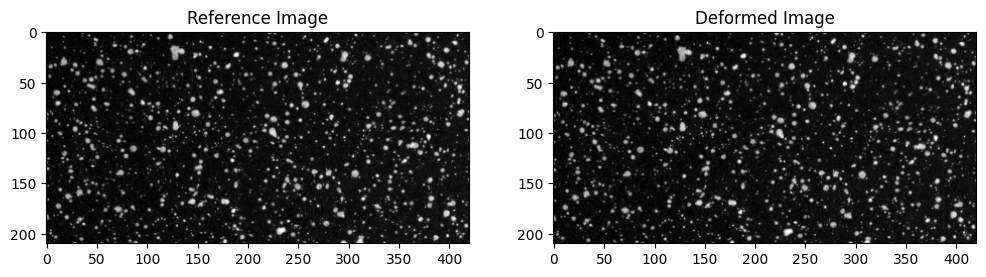

In [68]:
# ref_image = Image.open(r'D:\01 LeeBDa Personal File Floder\PINN-DIC\01\Crack experiment\Crack image lbd\001\001\001.png')
ref_image = Image.open(r'D:\01 LeeBDa Personal File Floder\PINN-DIC\01\Crack experiment\Crack image lbd\002\000.bmp')
ref_gray = ref_image.convert('L')
ref_gray = np.array(ref_gray)
RG = ref_gray[290:500,530:950]

# def_image = Image.open(r'D:\01 LeeBDa Personal File Floder\PINN-DIC\01\Crack experiment\Crack image lbd\001\001\060.png')
def_image = Image.open(r'D:\01 LeeBDa Personal File Floder\PINN-DIC\01\Crack experiment\Crack image lbd\002\014.bmp')
def_gray = def_image.convert('L')
def_gray = np.array(def_gray)
DG = def_gray[290:500,530:950]

xstart_index = 5
ystart_index = 5
yend_index = DG.shape[0] - 5
xend_index = DG.shape[1] - 5

ROI = np.ones_like(DG)

roi = np.zeros_like(DG)
roi[ystart_index:yend_index, xstart_index:xend_index] = 255

# sigma = 1.0  # 高斯核的标准差，可以根据需要调整
# RG = gaussian_filter(RG, sigma=sigma)
# DG = gaussian_filter(DG, sigma=sigma)

# # 绘制原始图像和插值后的图像
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.imshow(RG, cmap='gray')
plt.title('Reference Image')
plt.subplot(1, 2, 2)
plt.imshow(DG, cmap='gray')
plt.title('Deformed Image')
# cv2.imwrite(r'D:\01 LeeBDa Personal File Floder\PINN-DIC\01\Crack experiment\Crack image lbd\002\crack003_1.bmp', RG)
# cv2.imwrite(r'D:\01 LeeBDa Personal File Floder\PINN-DIC\01\Crack experiment\Crack image lbd\002\crack003_2.bmp', DG)
# cv2.imwrite(r'D:\01 LeeBDa Personal File Floder\PINN-DIC\01\Crack experiment\Crack image lbd\002\ROI.bmp', roi)

Epoch [1], Loss: 15.880813598632812, Lossf: 1711.251953125
Epoch [101], Loss: 6.683540344238281, Lossf: 43155.34375
Epoch [201], Loss: 6.548524379730225, Lossf: 33334.7890625
Epoch [301], Loss: 6.4539384841918945, Lossf: 27760.611328125
Epoch [401], Loss: 6.421207904815674, Lossf: 24117.513671875
Epoch [501], Loss: 6.395318984985352, Lossf: 21506.501953125
Epoch [601], Loss: 6.378030776977539, Lossf: 19834.28515625
Epoch [701], Loss: 6.369823932647705, Lossf: 18093.98828125
Epoch [801], Loss: 6.3563008308410645, Lossf: 16622.603515625
Epoch [901], Loss: 6.3325934410095215, Lossf: 15903.6923828125
****************over****************


(-0.5, 199.5, 204.5, -0.5)

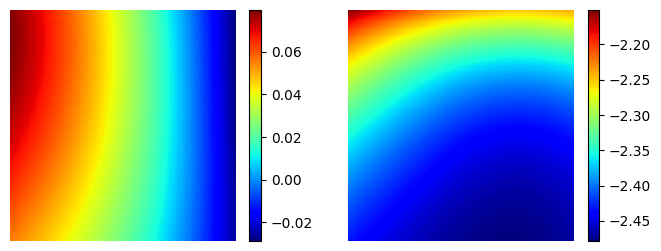

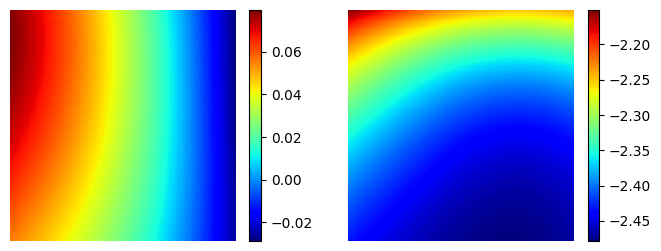

In [69]:
y_size, x_size = RG.shape
x_list = np.linspace(-1, 1, x_size)
y_list = np.linspace(-1, 1, y_size)
IX, IY = np.meshgrid(x_list, y_list)


# 网络结构
width = 50
model = PhysicsInformedNN1(RG, DG, ROI, width, IX, IY)
model.train_adam(1,1000)
# model.train(1)
print('****************over****************')
u,v = model.predict(IX, IY)

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.imshow(u[0][xstart_index:xend_index,
               ystart_index:yend_index], cmap='jet', interpolation='nearest')
plt.colorbar()
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(v[0][xstart_index:xend_index,
               ystart_index:yend_index], cmap='jet', interpolation='nearest')
plt.colorbar()
plt.axis('off')

# model.train_adam(2, 500)
# model.train(2)
u1,v1 = model.predict(IX, IY)
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.imshow(u1[0][xstart_index:xend_index,
               ystart_index:yend_index], cmap='jet', interpolation='nearest')
plt.colorbar()
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(v1[0][xstart_index:xend_index,
               ystart_index:yend_index], cmap='jet', interpolation='nearest')
plt.colorbar()
plt.axis('off')

Epoch [3001], Loss: 11.833505630493164, Lossf: 8066.76904296875
Epoch [3101], Loss: 11.74887466430664, Lossf: 7700.2392578125
Epoch [3201], Loss: 11.719361305236816, Lossf: 7362.60546875
Epoch [3301], Loss: 11.639219284057617, Lossf: 7279.0185546875
Epoch [3401], Loss: 11.56141185760498, Lossf: 6985.72412109375
Epoch [3501], Loss: 11.608925819396973, Lossf: 6825.890625
Epoch [3601], Loss: 11.601226806640625, Lossf: 6720.95947265625
Epoch [3701], Loss: 11.622057914733887, Lossf: 6368.00048828125
Epoch [3801], Loss: 11.518531799316406, Lossf: 6260.3818359375
Epoch [3901], Loss: 11.511954307556152, Lossf: 6131.2734375
Epoch [4001], Loss: 11.476425170898438, Lossf: 5933.7158203125
Epoch [4101], Loss: 11.409615516662598, Lossf: 5649.5263671875
Epoch [4201], Loss: 11.37604808807373, Lossf: 5635.4580078125
Epoch [4301], Loss: 11.376957893371582, Lossf: 5558.080078125
Epoch [4401], Loss: 11.722487449645996, Lossf: 5629.755859375
Epoch [4501], Loss: 11.4443941116333, Lossf: 5512.28369140625
Epo

(200, 410)

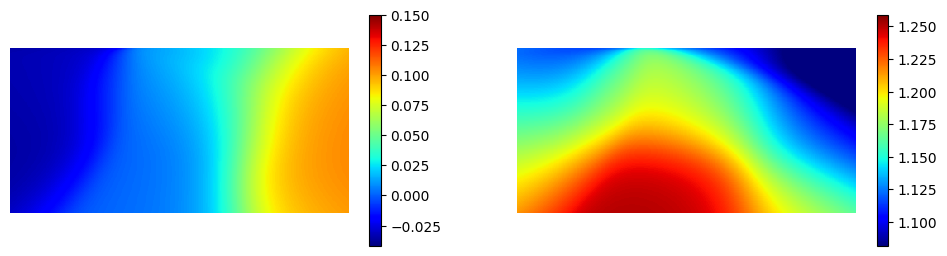

In [71]:
model.train_adam(2,2000)
# model.train(1)
# y_size, x_size = RG.shape
# x_list = np.linspace(-1, 1, x_size)
# y_list = np.linspace(-1, 1, y_size)
# IX, IY = np.meshgrid(x_list, y_list)
# width = 50
# model = PhysicsInformedNN1(RG, DG, ROI, width, IX, IY)
# model.dnn.load_state_dict(
#     torch.load(
#         r'D:\Jupyter\PINN in DIC\model parameters\crack_003_w50.pth'
#     )
# )
u,v = model.predict(IX, IY)
u = -u[0]/2
v = -v[0]/2

vmin_u=-0.042
vmax_u=0.15
vmin_v=1.0817
vmax_v=1.2586

xstart_index = 5
ystart_index = 5
xend_index = u.shape[0] - 5
yend_index = u.shape[1] - 5
u_sub = u[xstart_index:xend_index, ystart_index:yend_index]
v_sub = v[xstart_index:xend_index, ystart_index:yend_index] 

plt.figure(figsize=(12, 3))
normu = matplotlib.colors.Normalize(vmin=vmin_u, vmax=vmax_u)
normv = matplotlib.colors.Normalize(vmin=vmin_v, vmax=vmax_v)
plt.subplot(1, 2, 1)
plt.imshow(u_sub, cmap='jet', interpolation='nearest', norm=normu) # , norm=normu
plt.colorbar()
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(v_sub, cmap='jet', interpolation='nearest', norm=normv) # , norm=normv
plt.colorbar()
plt.axis('off')
u_sub.shape

(-1.0, 1.0, -1.0, 1.0)

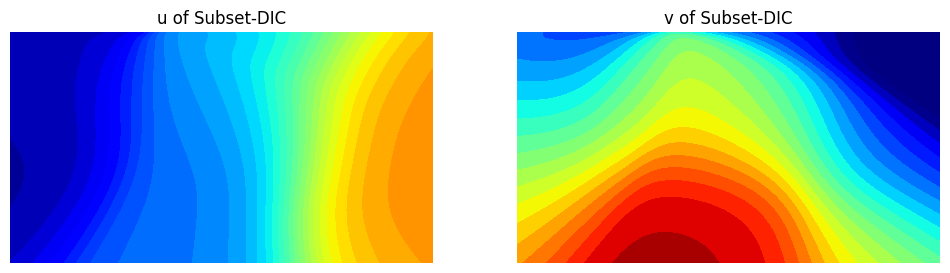

In [72]:
## 等值图

u_sub1 = np.flip(u_sub, axis=0)
v_sub1 = np.flip(v_sub, axis=0)
N = 30

y_size, x_size = u_sub1.shape
x_list = np.linspace(-1, 1, x_size)
y_list = np.linspace(-1, 1, y_size)
X, Y = np.meshgrid(x_list, y_list)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
c1 = ax1.contourf(X, Y, u_sub1, N, cmap='jet', vmin=vmin_u, vmax=vmax_u)
ax1.set_title('u of Subset-DIC')
ax1.axis('off')


c2 = ax2.contourf(X, Y, v_sub1, N, cmap='jet', vmin=vmin_v, vmax=vmax_v)
ax2.set_title('v of Subset-DIC')
ax2.axis('off')

(200, 410)

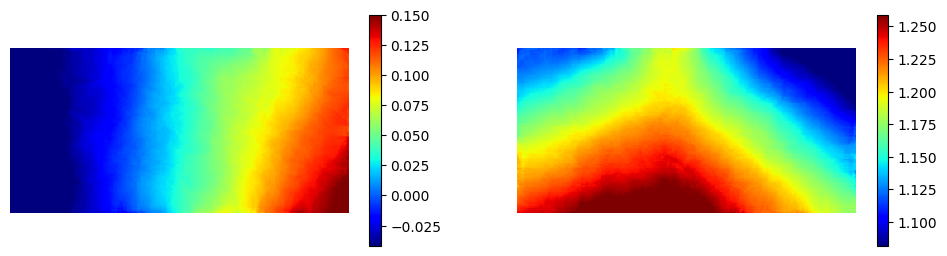

In [29]:
## 导入 NCORR 数据
filepath = r'D:\01 LeeBDa Personal File Floder\PINN-DIC\01\Crack experiment\Crack image lbd\002\uu_crack_003_02.mat'
dic_data = loadmat(filepath)
u_dic = dic_data['u']
v_dic = dic_data['v']

y_size, x_size = u_dic.shape
x_list = np.linspace(-1, 1, x_size)
y_list = np.linspace(-1, 1, y_size)
X, Y = np.meshgrid(x_list, y_list)

## 位移云图
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.imshow(u_dic, cmap='jet', interpolation='nearest', norm=normu) # , norm=normu
plt.colorbar()
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(v_dic, cmap='jet', interpolation='nearest', norm=normv) # , norm=normv
plt.colorbar()
plt.axis('off')

u_dic.shape


(-1.0, 1.0, -1.0, 1.0)

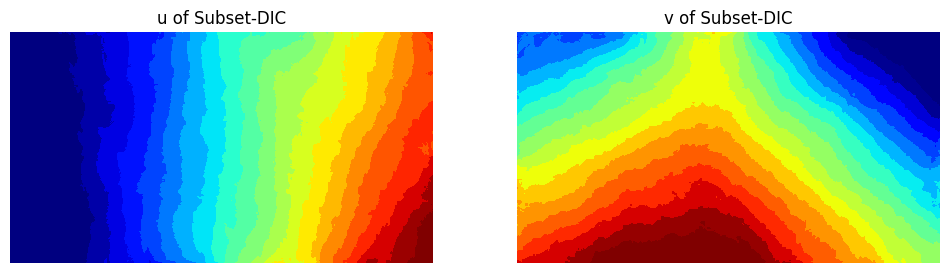

In [31]:
## 等值图
u_dic1 = np.flip(u_dic, axis=0)
v_dic1 = np.flip(v_dic, axis=0)
N = 30

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
c1 = ax1.contourf(X, Y, u_dic1, N, cmap='jet', vmin=vmin_u, vmax=vmax_u)
ax1.set_title('u of Subset-DIC')
ax1.axis('off')


c2 = ax2.contourf(X, Y, v_dic1, N, cmap='jet', vmin=vmin_v, vmax=vmax_v)
ax2.set_title('v of Subset-DIC')
ax2.axis('off')

In [30]:
data_to_save = {'u_PINN': u_sub, 'v_PINN': v_sub,
                'u_subset': u_dic, 'v_subset': v_dic}
scipy.io.savemat(f'crack_003_a.mat', data_to_save)

In [18]:
# torch.save(model.dnn.state_dict(), r'D:\Jupyter\PINN in DIC\model parameters\crack_006_w50.pth')

True

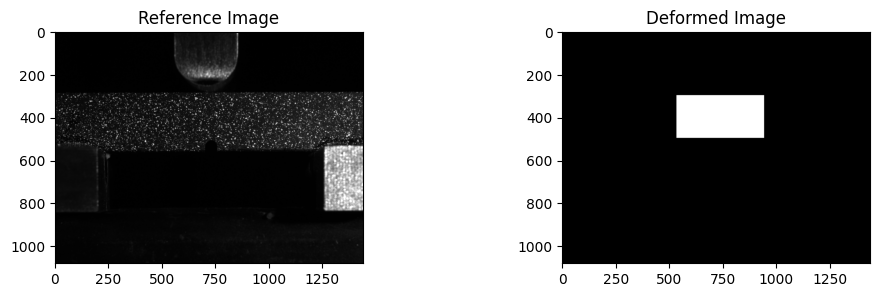

In [4]:
# ref_image = Image.open(r'D:\01 LeeBDa Personal File Floder\PINN-DIC\01\Crack experiment\Crack image lbd\001\001\001.png')
ref_image = Image.open(r'D:\01 LeeBDa Personal File Floder\PINN-DIC\01\Crack experiment\Crack image lbd\002\000.bmp')
ref_gray = ref_image.convert('L')
ref_gray = np.array(ref_gray)
RG = ref_gray

# def_image = Image.open(r'D:\01 LeeBDa Personal File Floder\PINN-DIC\01\Crack experiment\Crack image lbd\001\001\060.png')
def_image = Image.open(r'D:\01 LeeBDa Personal File Floder\PINN-DIC\01\Crack experiment\Crack image lbd\002\014.bmp')
def_gray = def_image.convert('L')
def_gray = np.array(def_gray)
DG = def_gray

# [290:500,530:950]
xstart_index = 5 + 530
ystart_index = 5 + 290
yend_index = 500 - 5
xend_index = 950 - 5

ROI = np.ones_like(DG)

roi = np.zeros_like(DG)
roi[ystart_index:yend_index, xstart_index:xend_index] = 255

# sigma = 1.0  # 高斯核的标准差，可以根据需要调整
# RG = gaussian_filter(RG, sigma=sigma)
# DG = gaussian_filter(DG, sigma=sigma)

# # 绘制原始图像和插值后的图像
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.imshow(RG, cmap='gray')
plt.title('Reference Image')
plt.subplot(1, 2, 2)
plt.imshow(roi, cmap='gray')
plt.title('Deformed Image')
# cv2.imwrite(r'D:\01 LeeBDa Personal File Floder\PINN-DIC\01\Crack experiment\Crack image lbd\002\crack003_1.bmp', RG)
# cv2.imwrite(r'D:\01 LeeBDa Personal File Floder\PINN-DIC\01\Crack experiment\Crack image lbd\002\crack003_2.bmp', DG)
cv2.imwrite(r'D:\01 LeeBDa Personal File Floder\PINN-DIC\01\Crack experiment\Crack image lbd\002\ROI1.bmp', roi)